In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import Workbook
from openpyxl.styles import Alignment
from openpyxl.utils import get_column_letter

datasets = ["ALL", "BTU", "HEC", "HFF", "SPS", "SSH"]
base_models = ["DecisionTree", "AdaBoost", "RandomForest", "HistGradientBoosting"]
metrics = ["accuracy", "balanced_accuracy", "f1_score", "precision", "recall", "stdev"]

def shorten_model_names(model):
    if model.startswith(base_models[3]):
        return model.replace(base_models[3], "HGB")
    elif model.startswith(base_models[2]):
        return model.replace(base_models[2], "RF")
    elif model.startswith(base_models[1]):
        return model.replace(base_models[1], "Ada")
    elif model.startswith(base_models[0]):
        return model.replace(base_models[0], "DTree")
    else:
        return model

fil = "wyniki.csv"
# fil = "wyniki_sel_features.csv"

df = pd.read_csv(fil, sep=';')
df = df.replace(-1, pd.NA)

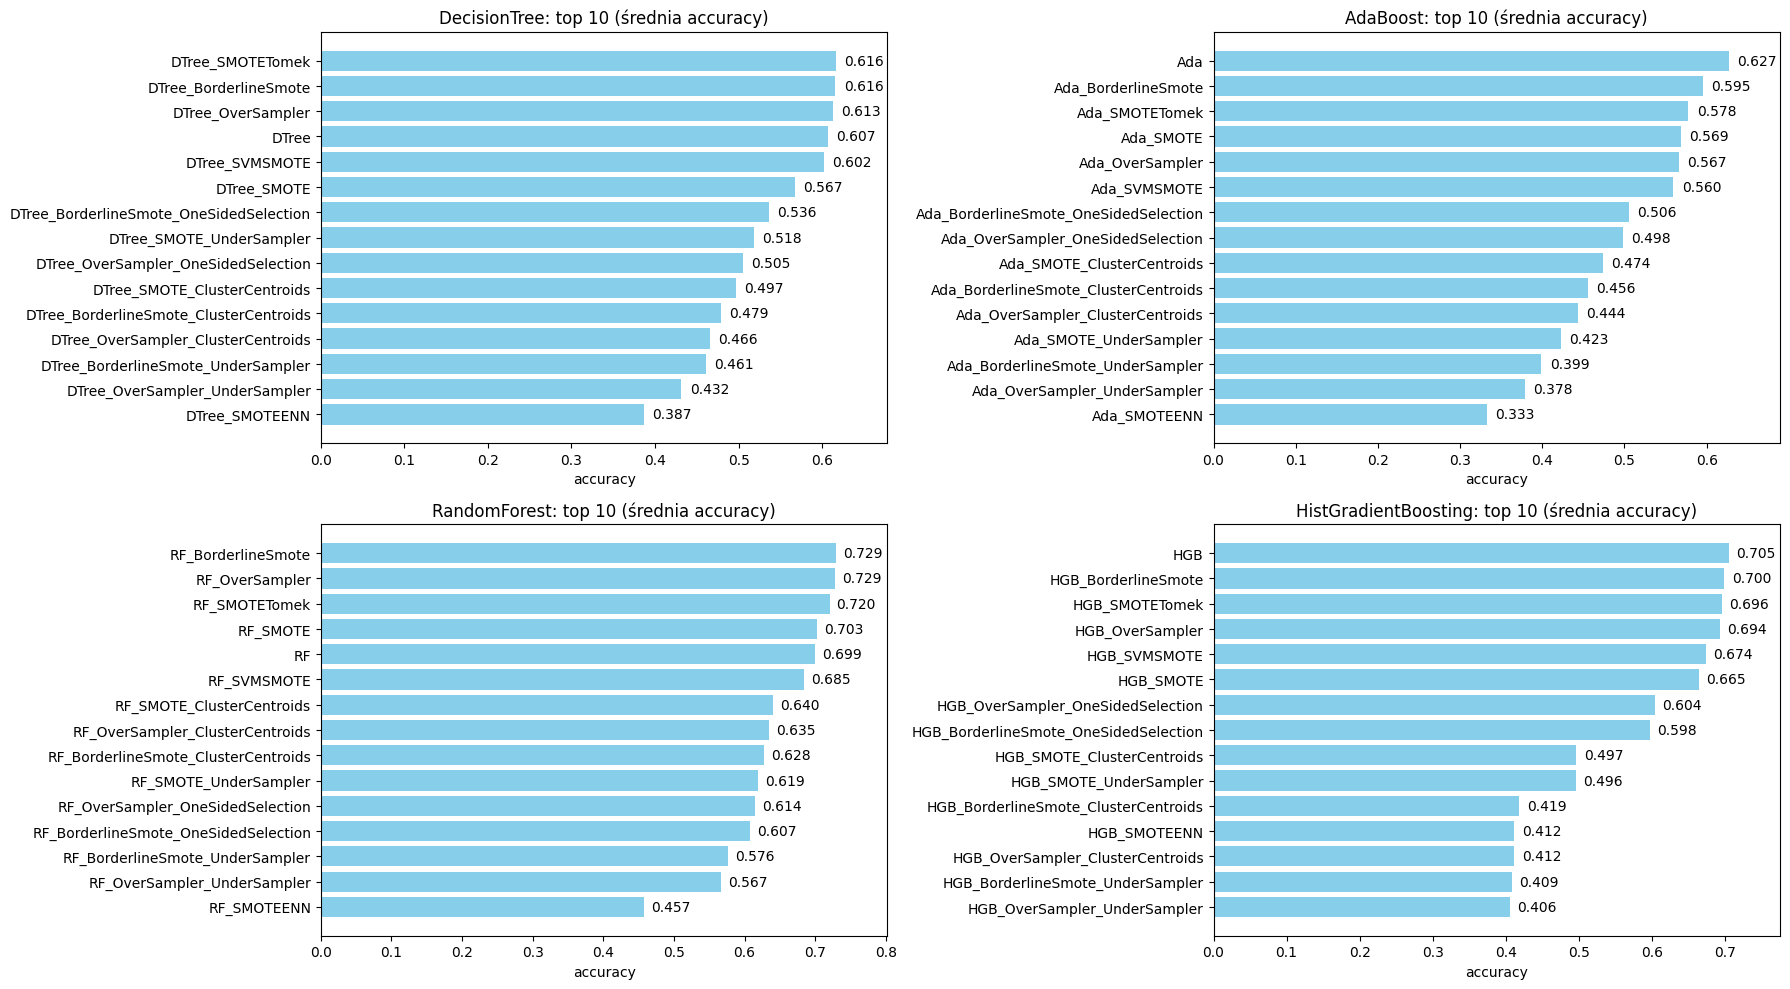

In [2]:
def model_plots(metric="accuracy"):
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes = axes.flatten()
    
    metric_cols = [f"{ds}_{metric}" for ds in datasets]
    for i, base in enumerate(base_models):
        ax = axes[i]

        model_rows = df[df["model"].str.startswith(base)].copy()
        if model_rows.empty:
            ax.set_title(f"{base}: brak danych")
            ax.axis("off")
            continue

        model_rows["metric_mean"] = (model_rows[metric_cols].mean(axis=1))

        valid = model_rows["metric_mean"].notna()
        top = model_rows[valid].sort_values("metric_mean", ascending=False) # .head(10)

        if top.empty:
            ax.set_title(f"{base}: brak danych")
            ax.axis("off")
            continue

        bars = ax.barh(
            top["model"].apply(shorten_model_names),
            top["metric_mean"],
            color="skyblue"
        )

        ax.set_title(f"{base}: top 10 (średnia {metric})")
        ax.set_xlabel(metric)
        ax.invert_yaxis()

        max_val = top["metric_mean"].max() * 1.1
        ax.set_xlim(0, max_val)

        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f"{width:.3f}", va="center")

    plt.tight_layout()
    plt.show()

model_plots(metric=metrics[0])

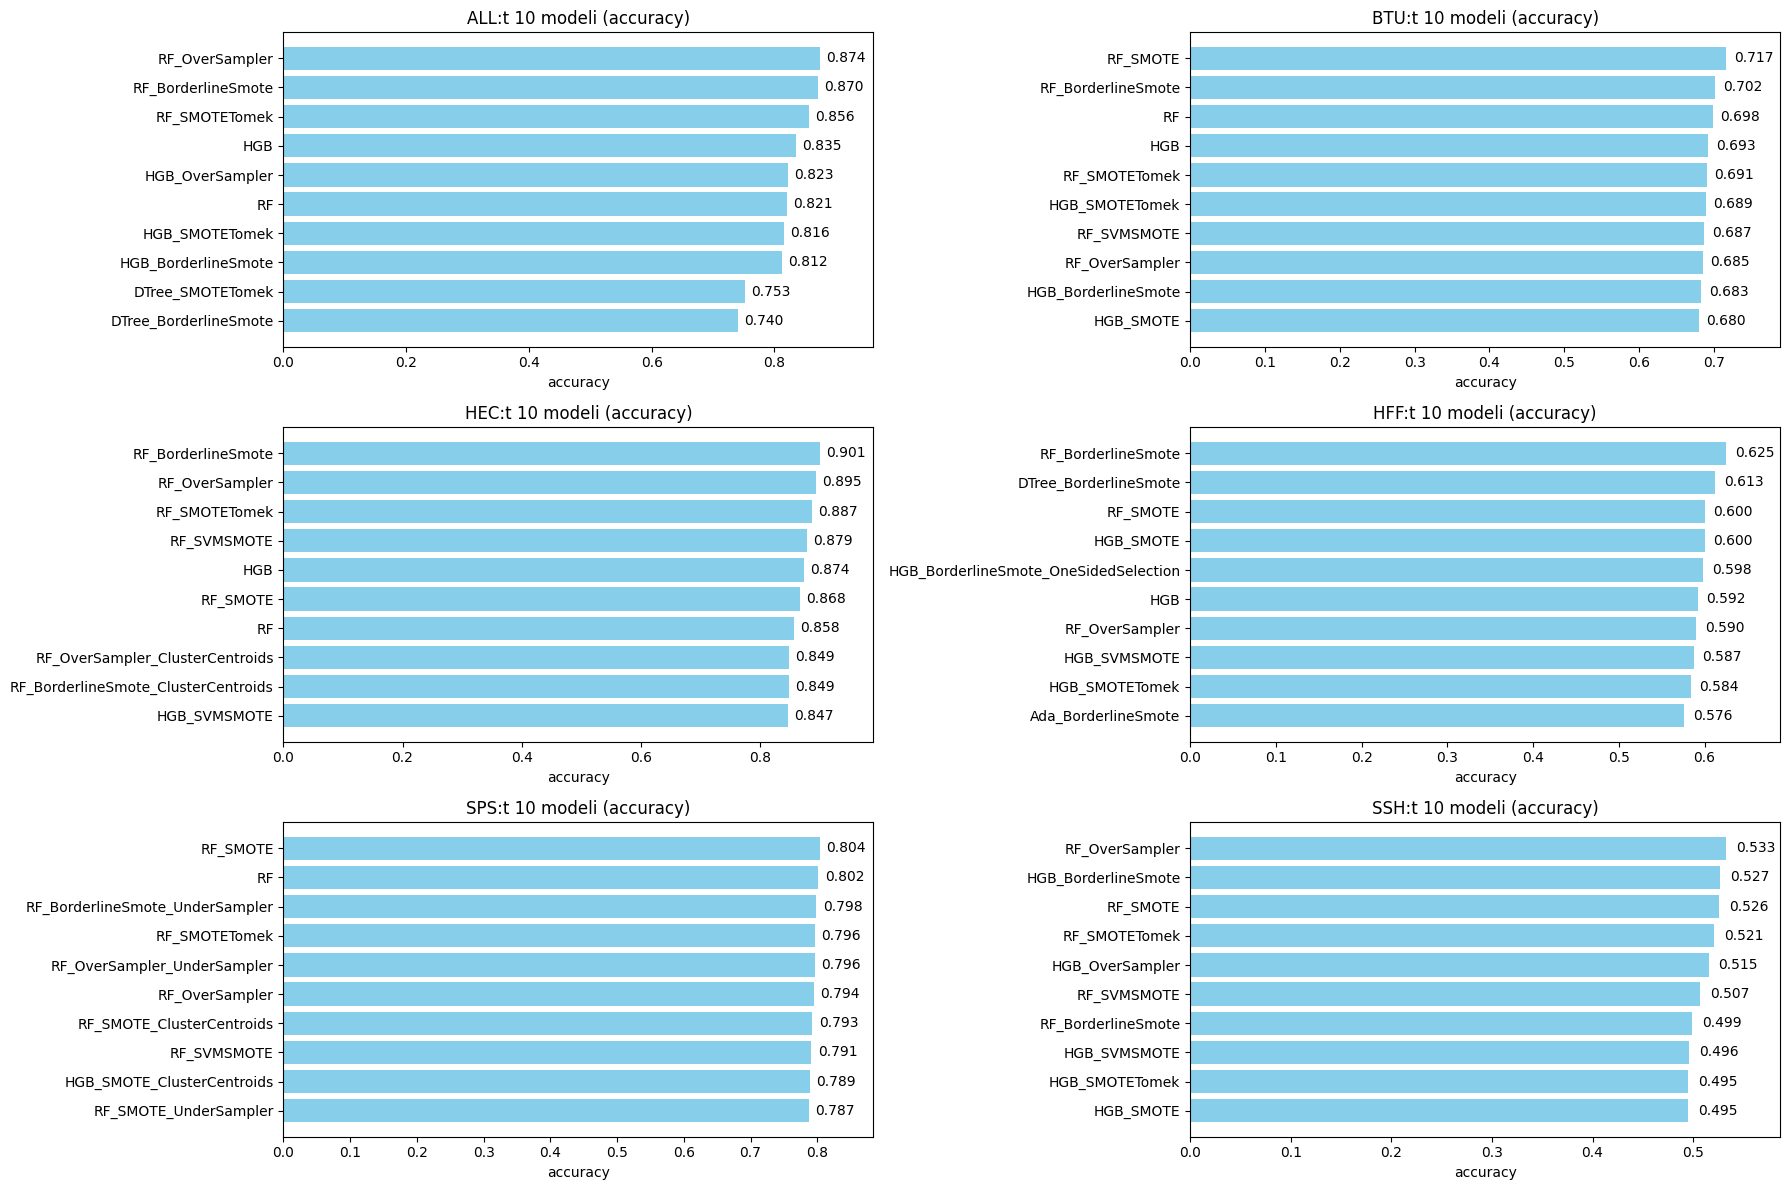

In [7]:
def dataset_plots(metric="accuracy"):
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    axes = axes.flatten()

    for i, ds in enumerate(datasets):
        ax = axes[i]
        col = f"{ds}_{metric}"
        

        df_tmp = df[df[col].notna()].sort_values(col, ascending=False).head(10)
        if df_tmp.empty:
            ax.set_title(f"{ds}: brak danych")
            ax.axis("off")
            continue
        
        bars = ax.barh(df_tmp["model"].apply(shorten_model_names), df_tmp[col], color='skyblue')
        ax.set_title(f"{ds}:t 10 modeli ({metric})")
        ax.set_xlabel(metric)
        ax.invert_yaxis()
        
        max_val = df_tmp[col].max() * 1.1
        ax.set_xlim(0, max_val)
        
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()

dataset_plots(metric=metrics[0])

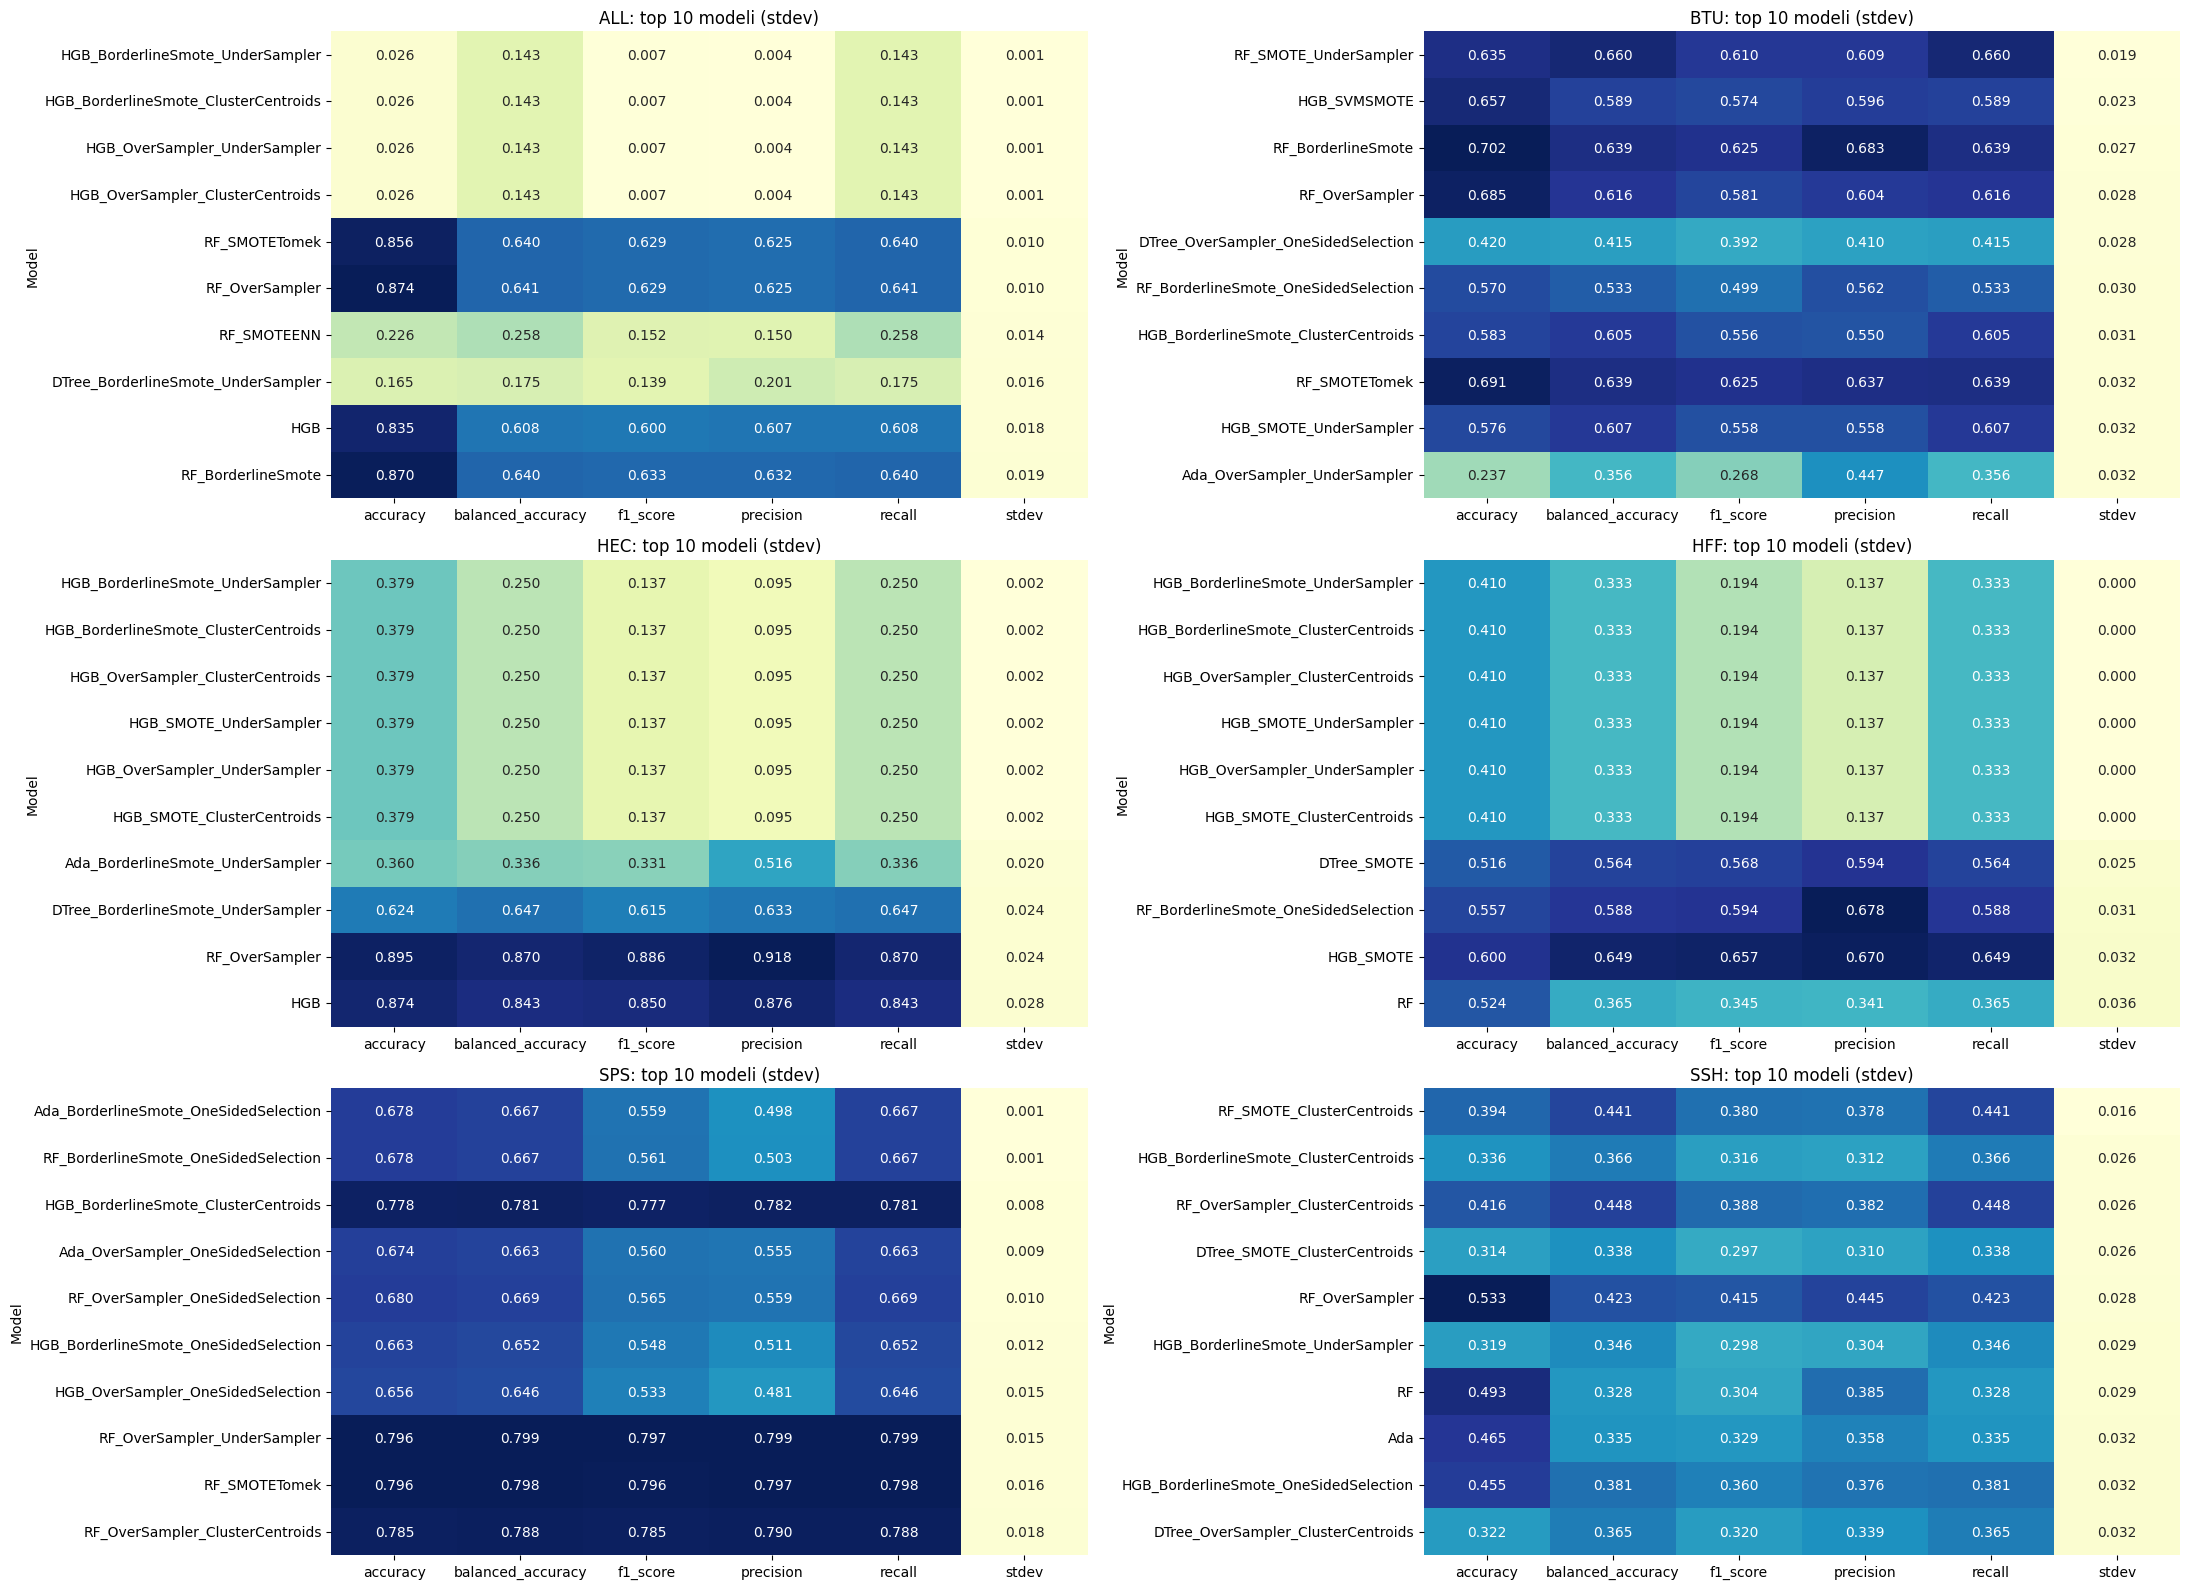

In [5]:
def heatmap_top10(sort_by="accuracy", ascending=False):
    fig, axes = plt.subplots(3, 2, figsize=(22, 16))
    axes = axes.flatten()
    
    for i, ds in enumerate(datasets):
        ax = axes[i]
        sort_col = f"{ds}_{sort_by}"
        cols = [f"{ds}_{m}" for m in metrics]
        
        valid = df[cols].notna().all(axis=1)
        df_tmp = df[valid].sort_values(sort_col, ascending=ascending).head(10)
        # df_tmp = df[valid].sort_values(sort_col, ascending=ascending)
        if df_tmp.empty:
            ax.set_title(f"{ds}: brak danych")
            ax.axis("off")
            continue
    
        heat_df = df_tmp[cols].copy()
        heat_df.index = df_tmp["model"].apply(shorten_model_names)
        heat_df.columns = metrics
        
        sns.heatmap(heat_df, annot=True, fmt=".3f", cmap="YlGnBu", cbar=False,  ax=ax)
        ax.set_title(f"{ds}: top 10 modeli ({sort_by})")
        # ax.set_xlabel("Metryka")
        ax.set_ylabel("Model")

    plt.tight_layout()
    plt.show()

heatmap_top10(metrics[5], ascending=True)

zapisywanie tabelki najlepszych kombinacji modeli dla modelu.

In [6]:
method_groups = {
    "Oversampling": ["SMOTE", "SVMSMOTE", "OverSampler", "BorderlineSmote"],
    "Undersampling": ["UnderSampler", "ClusterCentroids", "OneSidedSelection"],
    "Hybrid": ["SMOTEENN", "SMOTETomek"]
}

def detect_category(model_name):
    name = model_name.lower()
    has_over = False
    has_under = False
    
    for m in method_groups["Hybrid"]:
        if m.lower() in name:
            return "Hybrid"
    
    for m in method_groups["Oversampling"]:
        if m.lower() in name:
            has_over = True
            break
        
    for m in method_groups["Undersampling"]:
        if m.lower() in name:
            has_under = True
            break
    
    if has_over and has_under: return "Over+Under"
    elif has_over: return "Oversampling"
    elif has_under: return "Undersampling"
    else: return "Czysty"

def base_model(model_name):
    return model_name.split("_")[0]


output_path = "modele_tabele.xlsx"
writer = pd.ExcelWriter(output_path, engine='openpyxl')


for model in df["model"].apply(base_model).unique():
    subset = df[df["model"].str.startswith(model)]
    rows = []
    
    for _, row in subset.iterrows():
        model_name = row["model"]
        cat = detect_category(model_name)
        entry = {
            "model": model_name.replace(model, "").strip("_") or model_name,
            "kategoria": cat
        }
        for m in metrics:
            entry[m] = row[f"ALL_{m}"]
        rows.append(entry)
    
    out = pd.DataFrame(rows)
    category_order = ["Czysty", "Oversampling", "Undersampling", "Over+Under"]
    cat_map = {c: i for i, c in enumerate(category_order)}
    out["cat_order"] = out["kategoria"].map(cat_map)
    out = out.sort_values(["cat_order", "model"]).drop(columns=["cat_order"])

    out.to_excel(writer, sheet_name=model, index=False, startrow=1)
    
    ws = writer.sheets[model]
    ws.insert_rows(1)
    ws.merge_cells(start_row=1, start_column=1, end_row=1, end_column=out.shape[1])
    cell = ws.cell(row=1, column=1)
    cell.value = model
    cell.alignment = Alignment(horizontal='center')

writer.close()

print("Zapisano plik:", output_path)

Zapisano plik: modele_tabele.xlsx
